# Training

In [1]:
# !git clone https://github.com/adhiiisetiawan/nbr-time_aware_item_weighting
# %cd nbr-time_aware_item_weighting/
!pip install -r ../requirements.txt --quiet

DEPRECATION: celery 4.4.1 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# TODO: Set periode (per bulan, per 2 minggu, dll.) diisi dengan jumlah detik dalam satu periode
# contoh: "periode = 3600 * 24 * 30" untuk per bulan, "periode = 3600 * 24 * 7 * 2" untuk per 2 minggu

periode = "3600 * 24"

lst = []
with open('../nbr/common/constants.py', 'r') as f:
    lst = f.readlines()

with open('../nbr/common/constants.py', 'w') as f:
    lst[0] = f"TIME_SCALAR = {periode}\n"
    f.seek(0)
    f.writelines(lst)    

In [3]:
import sys
sys.path.append("..")
from nbr.preparation import Preprocess, save_split, Corpus
from nbr.trainer import NBRTrainer
from nbr.model import NBRKNN, RepurchaseModule
from tqdm import tqdm
import torch
import random
import numpy as np
import optuna
import warnings

warnings.filterwarnings("ignore")

In [4]:
seed = 10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [5]:
# TODO: Set apakah data perlu mem filter user dan item yang data transaksinya cukup sedikit
# Jika iya, min_user adalah minimal jumlah transaksi tiap user
# dan min_item minimal jumlah transaksi tiap item

filter = False
min_user = 0
min_item = 0

corpus_path = "data/"
dataset_name = "EPM-prep"

preprocessor = Preprocess(corpus_path, dataset_name)
preprocessor.load_data(min_user, min_item, filt=filter)
save_split(corpus_path, dataset_name, preprocessor)

Before preprocessing: #users = 576, #items = 1477, #clicks = 518655 (#illegal records = 0)
After preprocessing: #users = 576, #items = 1477, #clicks = 518655
Saving dataset in data//data_EPM-prep/...


In [6]:
corpus = Corpus(corpus_path, dataset_name)
corpus.load_data()

In [7]:
# Cek transaksi user 0
len(corpus.book[0]), corpus.book[0]

(1808,
  ...])

In [8]:
trainer = NBRTrainer(
    corpus=corpus,
    max_epochs=100,
    topk=10,
    early_stop_num=3
)

train dataset preparing...


 38%|███▊      | 216/576 [00:00<00:00, 2159.81it/s]

100%|██████████| 576/576 [00:00<00:00, 2086.98it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:04<00:00, 116.81it/s]


test dataset preparing...


100%|██████████| 539/539 [00:04<00:00, 119.51it/s]


In [9]:
slrc_best_params = {'batch_size': 256, 'lr': 0.00011201144001505824, 'l2_reg_coef': 0.00011498224071460201}

params = {
    "model": RepurchaseModule(
        item_num=corpus.n_items,
        avg_repeat_interval=corpus.total_avg_interval
    ),
    "batch_size": slrc_best_params["batch_size"],
    "lr": slrc_best_params["lr"],
    "l2_reg_coef": slrc_best_params["l2_reg_coef"]
}

trainer.init_hyperparams(**params)

In [10]:
# Cek data training user 0

for x in tqdm(trainer.train_dataloader):
    
    print()
    print('user_id:      ', x['user_id'][0])
    print('item_id:      ', x['item_id'][:100])
    print('click_time:   ', x['t'][:100])
    print('repeat_count:  ', x['length'][:100])
    break

  0%|          | 0/2007 [00:00<?, ?it/s]


user_id:       tensor(0)
item_id:       tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  4, 12, 13, 14, 15, 16,
        17, 18, 15,  8, 19, 20, 21, 22, 23,  0, 24, 11, 25, 26, 27, 28, 27, 24,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 13, 50, 51, 52, 17,  9, 53, 54, 55, 56, 57, 58, 59, 17, 50,
        11, 60, 61, 12, 29, 62, 61, 63, 64, 63, 65, 17, 66, 67, 17, 68,  1, 69,
        70, 71, 72, 17, 73, 74, 75, 76, 77, 32])
click_time:    tensor([18632., 18632., 18632., 18632., 18632., 18633., 18633., 18633., 18634.,
        18634., 18638., 18638., 18638., 18638., 18638., 18638., 18639., 18639.,
        18639., 18639., 18642., 18642., 18642., 18642., 18642., 18642., 18642.,
        18642., 18642., 18642., 18642., 18642., 18642., 18642., 18643., 18643.,
        18645., 18645., 18645., 18645., 18646., 18646., 18646., 18646., 18646.,
        18646., 18647., 18647., 18649., 18649., 18649., 18649., 18649., 18649.,
        18649.,

Epoch 1:


Batch loss = 0.684947: 100%|██████████| 2007/2007 [01:10<00:00, 28.47it/s]


Evaluation (dev):



100%|██████████| 539/539 [00:10<00:00, 52.18it/s] 

Epoch 2:



Batch loss = 0.684374: 100%|██████████| 2007/2007 [01:08<00:00, 29.16it/s]


Evaluation (dev):



100%|██████████| 539/539 [00:11<00:00, 47.33it/s]

Epoch 3:



Batch loss = 0.683818: 100%|██████████| 2007/2007 [01:11<00:00, 27.95it/s]


Evaluation (dev):



100%|██████████| 539/539 [00:10<00:00, 52.30it/s]

Epoch 4:



Batch loss = 0.683276: 100%|██████████| 2007/2007 [01:06<00:00, 29.99it/s]


Evaluation (dev):



100%|██████████| 539/539 [00:09<00:00, 56.64it/s] 

Epoch 5:



Batch loss = 0.682749: 100%|██████████| 2007/2007 [01:07<00:00, 29.63it/s]


Evaluation (dev):



100%|██████████| 539/539 [00:09<00:00, 53.94it/s] 

Epoch 6:



Batch loss = 0.682297: 100%|██████████| 2007/2007 [01:21<00:00, 24.63it/s]



Evaluation (dev):


100%|██████████| 539/539 [00:10<00:00, 51.16it/s] 


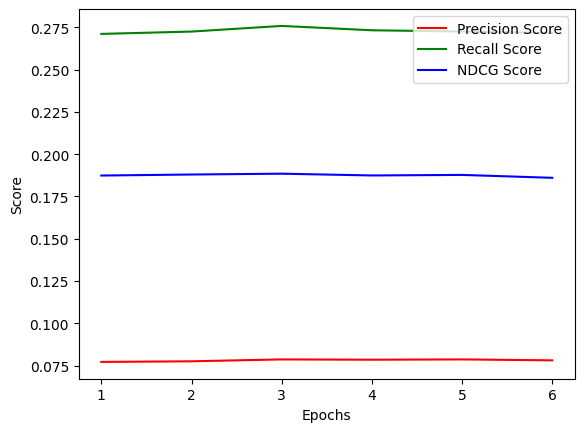

RepurchaseModule()

In [11]:
trainer.train()

In [12]:
# TODO: Set tanggal tertentu yang ingin diprediksi
# DEFAULT nya adalah tanggal terakhir pembelian tiap item

# date_to_predict = "2023-12-29"
date_to_predict = None

dev_user_emb, dev_data = trainer.get_predictions(mode="dev", timestamp=date_to_predict)
test_user_emb, test_data = trainer.get_predictions(mode="test", timestamp=date_to_predict)

100%|██████████| 539/539 [00:11<00:00, 48.34it/s] 


In [13]:
print('user_id:      ', test_data[0]['user_id'][0])
print('predict_time: ', test_data[0]['t'][0])

user_id:       tensor(0, dtype=torch.int32)
predict_time:  tensor(19629., dtype=torch.float64)


In [14]:
print(test_user_emb[0][:10])
print(test_data[0]['length'][:10])

[8.06530445e-111 0.00000000e+000 2.98350352e-283 2.86378232e-004
 2.69850051e-116 7.56513776e-229 0.00000000e+000 1.91060136e-068
 3.28232375e-265 4.57819491e-119]
tensor([11.,  4.,  4., 17., 11.,  3.,  3.,  6., 10.,  9.], dtype=torch.float64)


In [15]:
trainer2 = NBRTrainer(
    corpus=corpus,
    max_epochs=None,
    topk=10,
    early_stop_num=None
)

train dataset preparing...


  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:00<00:00, 1429.28it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:04<00:00, 127.22it/s]


test dataset preparing...


100%|██████████| 539/539 [00:04<00:00, 116.31it/s]


In [16]:
def objective(trial):
    params = {
        "model": NBRKNN(
            item_num=corpus.n_items,
            user_num=corpus.n_users,
            nearest_neighbors_num=trial.suggest_int("nearest_neighbors_num", low=1, high=200),
            alpha=trial.suggest_float("alpha", 0.0, 1.0, step=0.05),
            user_emb=dev_user_emb
        )
    }

    trainer2.init_hyperparams(**params)
    metrics = trainer2.evaluate(mode="dev")
    score = metrics["ndcg"]
    return score

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2023-11-15 09:28:50,630] A new study created in memory with name: no-name-58da6079-f5bf-4705-826b-f044e724b23c


100%|██████████| 539/539 [00:03<00:00, 154.00it/s]
[I 2023-11-15 09:28:54,408] Trial 0 finished with value: 0.0998907474414791 and parameters: {'nearest_neighbors_num': 155, 'alpha': 0.0}. Best is trial 0 with value: 0.0998907474414791.
100%|██████████| 539/539 [00:03<00:00, 153.88it/s]
[I 2023-11-15 09:28:57,991] Trial 1 finished with value: 0.12623541339756333 and parameters: {'nearest_neighbors_num': 127, 'alpha': 0.75}. Best is trial 1 with value: 0.12623541339756333.
100%|██████████| 539/539 [00:03<00:00, 169.55it/s]
[I 2023-11-15 09:29:01,248] Trial 2 finished with value: 0.11172362249059477 and parameters: {'nearest_neighbors_num': 100, 'alpha': 0.2}. Best is trial 1 with value: 0.12623541339756333.
100%|██████████| 539/539 [00:02<00:00, 183.60it/s]
[I 2023-11-15 09:29:04,274] Trial 3 finished with value: 0.13354174920065628 and parameters: {'nearest_neighbors_num': 40, 'alpha': 0.75}. Best is trial 3 with value: 0.13354174920065628.
100%|██████████| 539/539 [00:02<00:00, 185.60

In [17]:
trainer2 = NBRTrainer(
    corpus=corpus,
    max_epochs=None,
    topk=10,
    early_stop_num=None
)

params2 = {
    "model": NBRKNN(
        item_num=corpus.n_items,
        user_num=corpus.n_users,
        nearest_neighbors_num=study.best_params['nearest_neighbors_num'],
        alpha=study.best_params['alpha'],
        user_emb=test_user_emb
    )
}

# params["model"].set_emb(test_user_emb)

trainer2.init_hyperparams(**params2)
metrics = trainer2.evaluate(mode="test")
metrics

train dataset preparing...


100%|██████████| 576/576 [00:00<00:00, 2285.78it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:05<00:00, 106.65it/s]


test dataset preparing...


100%|██████████| 539/539 [00:03<00:00, 155.96it/s]


{'precision': 0.09795918367346938,
 'recall': 0.298977758412329,
 'ndcg': 0.22287361170550415}

In [18]:
import pandas as pd

data = pd.read_csv('data/EPM.csv', index_col=None)
sorted_data = data.sort_values(['ship_to_id', 'trx_date']).reset_index(drop=True)

In [21]:
def inference(user, topk):
    n_items = corpus.n_items

    items_scores = trainer2.model.predict_for_user(user).view(-1, n_items)
    top_items = torch.topk(items_scores, k=topk, dim=1, sorted=True).indices
    top_score = [float(i) for i in items_scores[0]]

    print(sorted(data['ship_to_id'].unique())[user])
    print("Item  | Score")
    print('-------------')
    total = sum(items_scores[0])
    for i in top_items[0]:
        print("{:5} | {:<5} | {}%".format(sorted_data['item_code'].unique()[int(i)], round(top_score[i], 3), round(top_score[i] / float(total) * 100, 2)))
    print()

top_k = 10
user_id = 0

inference(user_id, top_k)

EPM_1096687
Item  | Score
-------------
BLCCC | 0.116 | 18.42%
ENR04 | 0.098 | 15.55%
BLCBC | 0.097 | 15.36%
BLPAN | 0.094 | 14.93%
MCDHP | 0.087 | 13.86%
TAGNA | 0.027 | 4.3%
TRLSC | 0.027 | 4.29%
HCO01 | 0.01  | 1.59%
CRTDV | 0.01  | 1.54%
CRTDS | 0.009 | 1.5%



# Load

In [1]:
# !git clone https://github.com/adhiiisetiawan/nbr-time_aware_item_weighting
# %cd nbr-time_aware_item_weighting/
!pip install -r ../requirements.txt --quiet

DEPRECATION: celery 4.4.1 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import sys
sys.path.append("..")
from nbr.preparation import Preprocess, save_split, Corpus
from nbr.trainer import NBRTrainer
from nbr.model import NBRKNN, RepurchaseModule
import torch
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
seed = 10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
corpus_path = "data/"
dataset_name = "EPM-prep"

preprocessor = Preprocess(corpus_path, dataset_name)
preprocessor.load_data(0, 0, filt=False)
save_split(corpus_path, dataset_name, preprocessor)

corpus = Corpus(corpus_path, dataset_name)
corpus.load_data()

Before preprocessing: #users = 465, #items = 1477, #clicks = 518655 (#illegal records = 0)
After preprocessing: #users = 465, #items = 1477, #clicks = 518655
Saving dataset in data//data_EPM-prep/...


In [5]:
trainer = NBRTrainer(
    corpus=corpus,
    max_epochs=100,
    topk=10,
    early_stop_num=3
)

slrc_best_params = {'batch_size': 256, 'lr': 0.00011201144001505824, 'l2_reg_coef': 0.00011498224071460201}

params = {
    "model": RepurchaseModule(
        item_num=corpus.n_items,
        avg_repeat_interval=corpus.total_avg_interval
    ),
    "batch_size": slrc_best_params["batch_size"],
    "lr": slrc_best_params["lr"],
    "l2_reg_coef": slrc_best_params["l2_reg_coef"]
}

trainer.init_hyperparams(**params)
with open("best_checkpoint.pth", "rb") as f:
    checkpoint = torch.load(f)
    trainer.model.load_state_dict(checkpoint)

train dataset preparing...


  0%|          | 0/465 [00:00<?, ?it/s]

100%|██████████| 465/465 [00:00<00:00, 2085.11it/s]


dev dataset preparing...


100%|██████████| 453/453 [00:04<00:00, 94.70it/s] 


test dataset preparing...


100%|██████████| 453/453 [00:04<00:00, 105.35it/s]


In [6]:
dev_user_emb = trainer.get_predictions(mode="dev")
test_user_emb = trainer.get_predictions(mode="test")

100%|██████████| 453/453 [00:07<00:00, 58.67it/s] 


In [59]:
trainer = NBRTrainer(
    corpus=corpus,
    max_epochs=None,
    topk=5,
    early_stop_num=None
)

# HARD CODED based on training process
best_study = {
    'nearest_neighbors_num': 138,
    'alpha': 1.0
}

params = {
    "model": NBRKNN(
        item_num=corpus.n_items,
        user_num=corpus.n_users,
        nearest_neighbors_num=best_study["nearest_neighbors_num"],
        alpha=best_study["alpha"],
        user_emb=dev_user_emb
    )
}
params["model"].set_emb(test_user_emb)

trainer.init_hyperparams(**params)
trainer.evaluate(mode='test')

train dataset preparing...


100%|██████████| 576/576 [00:00<00:00, 730.77it/s]


dev dataset preparing...


100%|██████████| 539/539 [00:10<00:00, 49.06it/s] 


test dataset preparing...


100%|██████████| 539/539 [00:06<00:00, 81.73it/s] 


{'precision': 0.17662337662337663,
 'recall': 0.27805139881027735,
 'ndcg': 0.24104515041644908}

In [9]:
import pandas as pd

data = pd.read_csv('data/EPM.csv')

In [10]:
def inference(user, topk):
    n_items = corpus.n_items

    items_scores = trainer.model.predict_for_user(user).view(-1, n_items)
    top_items = torch.topk(items_scores, k=topk, dim=1, sorted=True).indices
    top_score = [float(i) for i in items_scores[0]]

    print(sorted(data['customer_name'].unique())[user])
    print("Item  | Score")
    print('-------------')
    for i in top_items[0]:
        print("{:5} | {:<5}".format(sorted(data['item_code'].unique())[int(i)], round(top_score[i], 3)))
    print()

top_k = 5
user_id = 1

inference(433, 5)
# for i in [1, 12, 123]:
#     inference(i, top_k)

JK1-APOTEK JATI FARMA_GROUP_NA
Item  | Score
-------------
10224 | 0.0  
10225 | 0.0  
00869 | 0.0  
00868 | 0.0  
10223 | 0.0  



In [11]:
trainer.evaluate_fully(mode='test', topk=[1, 3, 5, 10, 50])

100%|██████████| 453/453 [00:03<00:00, 142.01it/s]


{'precision': {'@1': 0.22075055187637968,
  '@3': 0.17218543046357615,
  '@5': 0.15275938189845475,
  '@10': 0.11567328918322298,
  '@50': 0.05479028697571744},
 'recall': {'@1': 0.10169930093392149,
  '@3': 0.20035191720972317,
  '@5': 0.2714082047816094,
  '@10': 0.3663527527189077,
  '@50': 0.6636623068713118},
 'ndcg': {'@1': 0.11970787570639996,
  '@3': 0.1941751650231531,
  '@5': 0.23378956977790813,
  '@10': 0.2778382944080823,
  '@50': 0.37954528318269803}}